In [1]:
import sys
sys.path.append('../..')
from src.core.GameInstance import apply_react, reaction, GameInstance
from src.core.GameState import Location, Aura, GameState, Box
from src.game import activate, Game, fake_callback
from src.agent.alphabeta import Searcher
from src.core.Event import Event, Death, Switch
from src.agent.MCTS import *

In [2]:
#net = CatNet()
net = PrinceNet()

In [3]:
net.to('cuda')

PrinceNet(
  (encoder): Sequential(
    (0): Linear(in_features=190, out_features=190, bias=True)
    (1): ReLU()
  )
  (hid): Sequential(
    (0): Linear(in_features=190, out_features=50, bias=True)
    (1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (policy_head): Sequential(
    (0): Linear(in_features=50, out_features=6, bias=True)
    (1): LogSoftmax(dim=-1)
  )
  (avgpool): AvgPool1d(kernel_size=(10,), stride=(10,), padding=(0,))
  (maxpool): MaxPool1d(kernel_size=10, stride=10, padding=0, dilation=1, ceil_mode=False)
  (value_head): Sequential(
    (0): Linear(in_features=10, out_features=1, bias=True)
    (1): Tanh()
  )
  (imp_head): Sequential(
    (0): Linear(in_features=10, out_features=3, bias=True)
    (1): Sigmoid()
  )
  (round_head): Sequential(
    (0): Linear(in_features=10, out_features=15, bias=True)
    (1): Softmax(dim=-1)
  )
  (hp_head): Sequential(
    (0): Linear(in_features=10, out_features=60, bias=

In [4]:
import torch
#checkpoint = torch.load('./princeNet100.pt')
#net.load_state_dict(checkpoint['model'])
#del checkpoint
mcts = MCTS(net,'../../src/agent/ids.json')
coach = PrinceTrainer(mcts, '.')
randomplayer = RandomPlayer()

In [5]:
coach.train(10, 50, name = 'princeNet', sims = 30,lr = 0.06)
#coach.test(Searcher(), 20, time_per_step = 0.05, verbose = True)

iter = 0


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [12:43<00:00, 15.27s/it]


test win rate = 0.0
iter = 1


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [20:38<00:00, 24.77s/it]


test win rate = 0.0
iter = 2


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [09:02<00:00, 10.85s/it]


test win rate = 0.2
iter = 3


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [09:27<00:00, 11.36s/it]


test win rate = 0.0
iter = 4


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [08:42<00:00, 10.45s/it]


test win rate = 0.0
iter = 5


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [09:43<00:00, 11.66s/it]


test win rate = 0.0
iter = 6


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [09:24<00:00, 11.30s/it]


test win rate = 0.4
iter = 7


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [07:37<00:00,  9.16s/it]


test win rate = 0.3
iter = 8


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [08:05<00:00,  9.71s/it]


test win rate = 0.6
iter = 9


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [07:21<00:00,  8.83s/it]


test win rate = 0.0


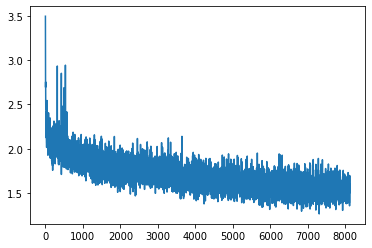

In [6]:
#coach.train(20, 100, sims = 15,lr = 0.05)
import matplotlib.pyplot as plot
loss = coach.loss
plot.plot(list(range(len(loss))), loss)

In [ ]:
def input_callback(g, event, *args):
    #print("yes i am here")
    if isinstance(event, Death) and g.history['phase'] == 'deathswitch':
        active = g.getactive(event.player_id)
        direct = int(input('your switch(1 for next, -1 for previous):'))
        return Switch(g.nexteid(), event.eid, event.player_id, active, direct)
    else:
        return Event(-1,-1,-1)
player = int(input('your player_id is:'))
Master = mcts
def callback(g, event, *args):
    if event.player_id == player:
        return input_callback(g,event,*args)
    else:
        return Master.callback(g,event,*args)

b1 = Box(['Fischl','Ayaka','Sucrose'],[])
b2 = Box(['Diluc','Kaeya','Sucrose'],[])
state = GameState(b1,b2)
g = Game(state)
g.initiate(0, 0, fake_callback)
while not g.terminated():
    #player = 1
    print("mover = ", g.mover)
    if g.mover != player:
        #m, s, d = Master.search(5, g)
        m = Master.search(g,5, sims = 100)
        #m, s, d = Rival.search(5, g)
        #m = g.getIns(1, 'switch next')
        print("move = ", m)
        g.proceed(m,False, callback)
        #nodes = Master.nodes
        print("pi = ", Master.pi)
        #print("depth = {}, total nodes = {}, score = {}".format(d,nodes,s))
    elif g.mover == player:
        m = input("your move:")
        m = g.getIns(player, m)
        #m, s, d = Rival.search(5, g)
        g.proceed(m,False, callback)
        #print("move = ",m)
        #nodes = Rival.nodes
    else:
        print("mover = ", g.mover)
        break
    #print("player {} makes a move {}".format(player, m))
    print("hp distribution: ")
    print("p1 = ",[c.hp for c in g.g.p1.char],'\t\t','p2 = ', [c.hp for c in g.g.p2.char] )
    print("p1 active = ",g.g.p1.history['active'], ' p2 active = ', g.g.p2.history['active'])
    print("p1 end = ",g.g.p1.history['endround'], 'p2 end = ',g.g.p2.history['endround'])
    print("p1 aura = ", g.g.p1.getAura(), ' p2 aura = ', g.g.p2.getAura())
    print()

your player_id is: 2


mover =  1
move =  UseKit(player_id=1, dice_pattern=DicePattern(pyro=0, cryo=0, hydro=0, electro=3, dendro=0, anemo=0, geo=0, black=0, white=0, omni=0), real_dice_pattern=DicePattern(pyro=0, cryo=0, hydro=0, electro=3, dendro=0, anemo=0, geo=0, black=0, white=0, omni=0), dice_instance=DiceInstance(omni=3, pyro=0, cryo=0, hydro=0, electro=0, dendro=0, anemo=0, geo=0), kit='skill')
pi =  tensor([0.0000, 0.9583, 0.0104, 0.0000, 0.0312, 0.0000])
hp distribution: 
p1 =  [10, 10, 10] 		 p2 =  [9, 10, 10]
p1 active =  0  p2 active =  0
p1 end =  False p2 end =  False
p1 aura =  [<Aura.empty: 0>, <Aura.empty: 0>, <Aura.empty: 0>]  p2 aura =  [<Aura.electro: 3>, <Aura.empty: 0>, <Aura.empty: 0>]

mover =  2


your move: skill


hp distribution: 
p1 =  [7, 10, 10] 		 p2 =  [9, 10, 10]
p1 active =  0  p2 active =  0
p1 end =  False p2 end =  False
p1 aura =  [<Aura.pyro: 1>, <Aura.empty: 0>, <Aura.empty: 0>]  p2 aura =  [<Aura.electro: 3>, <Aura.empty: 0>, <Aura.empty: 0>]

mover =  1
move =  Switch(player_id=1, dice_pattern=DicePattern(pyro=0, cryo=0, hydro=0, electro=0, dendro=0, anemo=0, geo=0, black=0, white=0, omni=1), real_dice_pattern=DicePattern(pyro=0, cryo=0, hydro=0, electro=0, dendro=0, anemo=0, geo=0, black=0, white=0, omni=1), dice_instance=DiceInstance(omni=1, pyro=0, cryo=0, hydro=0, electro=0, dendro=0, anemo=0, geo=0), direction=-1)
pi =  tensor([0.0000, 0.0309, 0.0722, 0.0000, 0.8969, 0.0000])
hp distribution: 
p1 =  [7, 10, 10] 		 p2 =  [9, 10, 10]
p1 active =  2  p2 active =  0
p1 end =  False p2 end =  False
p1 aura =  [<Aura.pyro: 1>, <Aura.empty: 0>, <Aura.empty: 0>]  p2 aura =  [<Aura.electro: 3>, <Aura.empty: 0>, <Aura.empty: 0>]

mover =  2


your move: switch next


hp distribution: 
p1 =  [7, 10, 10] 		 p2 =  [9, 10, 10]
p1 active =  2  p2 active =  1
p1 end =  False p2 end =  False
p1 aura =  [<Aura.pyro: 1>, <Aura.empty: 0>, <Aura.empty: 0>]  p2 aura =  [<Aura.electro: 3>, <Aura.empty: 0>, <Aura.empty: 0>]

mover =  1
move =  UseKit(player_id=1, dice_pattern=DicePattern(pyro=0, cryo=0, hydro=0, electro=0, dendro=0, anemo=3, geo=0, black=0, white=0, omni=0), real_dice_pattern=DicePattern(pyro=0, cryo=0, hydro=0, electro=0, dendro=0, anemo=3, geo=0, black=0, white=0, omni=0), dice_instance=DiceInstance(omni=3, pyro=0, cryo=0, hydro=0, electro=0, dendro=0, anemo=0, geo=0), kit='skill')
pi =  tensor([0., 1., 0., 0., 0., 0.])
hp distribution: 
p1 =  [7, 10, 10] 		 p2 =  [9, 7, 10]
p1 active =  2  p2 active =  0
p1 end =  False p2 end =  False
p1 aura =  [<Aura.pyro: 1>, <Aura.empty: 0>, <Aura.empty: 0>]  p2 aura =  [<Aura.electro: 3>, <Aura.empty: 0>, <Aura.empty: 0>]

mover =  2


your move: skill


hp distribution: 
p1 =  [7, 10, 7] 		 p2 =  [9, 7, 10]
p1 active =  2  p2 active =  0
p1 end =  False p2 end =  False
p1 aura =  [<Aura.pyro: 1>, <Aura.empty: 0>, <Aura.pyro: 1>]  p2 aura =  [<Aura.electro: 3>, <Aura.empty: 0>, <Aura.empty: 0>]

mover =  1
move =  EndRound(player_id=1, dice_pattern=None, real_dice_pattern=None, dice_instance=None)
pi =  tensor([0.0000, 0.0000, 0.0000, 0.0816, 0.0000, 0.9184])
hp distribution: 
p1 =  [7, 10, 7] 		 p2 =  [9, 7, 10]
p1 active =  2  p2 active =  0
p1 end =  True p2 end =  False
p1 aura =  [<Aura.pyro: 1>, <Aura.empty: 0>, <Aura.pyro: 1>]  p2 aura =  [<Aura.electro: 3>, <Aura.empty: 0>, <Aura.empty: 0>]

mover =  2


your move: switch next


hp distribution: 
p1 =  [7, 10, 7] 		 p2 =  [9, 7, 10]
p1 active =  2  p2 active =  1
p1 end =  True p2 end =  False
p1 aura =  [<Aura.pyro: 1>, <Aura.empty: 0>, <Aura.pyro: 1>]  p2 aura =  [<Aura.electro: 3>, <Aura.empty: 0>, <Aura.empty: 0>]

mover =  2


your move: end round


hp distribution: 
p1 =  [7, 10, 7] 		 p2 =  [9, 6, 10]
p1 active =  2  p2 active =  1
p1 end =  False p2 end =  False
p1 aura =  [<Aura.pyro: 1>, <Aura.empty: 0>, <Aura.pyro: 1>]  p2 aura =  [<Aura.electro: 3>, <Aura.electro: 3>, <Aura.empty: 0>]

mover =  1
move =  UseKit(player_id=1, dice_pattern=DicePattern(pyro=0, cryo=0, hydro=0, electro=0, dendro=0, anemo=3, geo=0, black=0, white=0, omni=0), real_dice_pattern=DicePattern(pyro=0, cryo=0, hydro=0, electro=0, dendro=0, anemo=3, geo=0, black=0, white=0, omni=0), dice_instance=DiceInstance(omni=3, pyro=0, cryo=0, hydro=0, electro=0, dendro=0, anemo=0, geo=0), kit='skill')
pi =  tensor([0., 1., 0., 0., 0., 0.])
hp distribution: 
p1 =  [7, 10, 7] 		 p2 =  [8, 3, 9]
p1 active =  2  p2 active =  0
p1 end =  False p2 end =  False
p1 aura =  [<Aura.pyro: 1>, <Aura.empty: 0>, <Aura.pyro: 1>]  p2 aura =  [<Aura.electro: 3>, <Aura.empty: 0>, <Aura.electro: 3>]

mover =  2


your move: switch next


hp distribution: 
p1 =  [7, 10, 7] 		 p2 =  [8, 3, 9]
p1 active =  2  p2 active =  1
p1 end =  False p2 end =  False
p1 aura =  [<Aura.pyro: 1>, <Aura.empty: 0>, <Aura.pyro: 1>]  p2 aura =  [<Aura.electro: 3>, <Aura.empty: 0>, <Aura.electro: 3>]

mover =  1
move =  UseKit(player_id=1, dice_pattern=DicePattern(pyro=0, cryo=0, hydro=0, electro=0, dendro=0, anemo=3, geo=0, black=0, white=0, omni=0), real_dice_pattern=DicePattern(pyro=0, cryo=0, hydro=0, electro=0, dendro=0, anemo=3, geo=0, black=0, white=0, omni=0), dice_instance=DiceInstance(omni=3, pyro=0, cryo=0, hydro=0, electro=0, dendro=0, anemo=0, geo=0), kit='burst')
pi =  tensor([1., 0., 0., 0., 0., 0.])
hp distribution: 
p1 =  [7, 10, 7] 		 p2 =  [8, 2, 9]
p1 active =  2  p2 active =  1
p1 end =  False p2 end =  False
p1 aura =  [<Aura.pyro: 1>, <Aura.empty: 0>, <Aura.pyro: 1>]  p2 aura =  [<Aura.electro: 3>, <Aura.empty: 0>, <Aura.electro: 3>]

mover =  2


your move: skill


hp distribution: 
p1 =  [7, 10, 2] 		 p2 =  [8, 2, 9]
p1 active =  2  p2 active =  1
p1 end =  False p2 end =  False
p1 aura =  [<Aura.pyro: 1>, <Aura.empty: 0>, <Aura.empty: 0>]  p2 aura =  [<Aura.electro: 3>, <Aura.empty: 0>, <Aura.electro: 3>]

mover =  1
move =  Switch(player_id=1, dice_pattern=DicePattern(pyro=0, cryo=0, hydro=0, electro=0, dendro=0, anemo=0, geo=0, black=0, white=0, omni=1), real_dice_pattern=DicePattern(pyro=0, cryo=0, hydro=0, electro=0, dendro=0, anemo=0, geo=0, black=0, white=0, omni=1), dice_instance=DiceInstance(omni=1, pyro=0, cryo=0, hydro=0, electro=0, dendro=0, anemo=0, geo=0), direction=1)
pi =  tensor([0., 0., 0., 1., 0., 0.])
hp distribution: 
p1 =  [7, 10, 2] 		 p2 =  [8, 2, 9]
p1 active =  0  p2 active =  1
p1 end =  False p2 end =  False
p1 aura =  [<Aura.pyro: 1>, <Aura.empty: 0>, <Aura.empty: 0>]  p2 aura =  [<Aura.electro: 3>, <Aura.empty: 0>, <Aura.electro: 3>]

mover =  2


your move: skill


hp distribution: 
p1 =  [2, 10, 2] 		 p2 =  [8, 2, 9]
p1 active =  0  p2 active =  1
p1 end =  False p2 end =  False
p1 aura =  [<Aura.empty: 0>, <Aura.empty: 0>, <Aura.empty: 0>]  p2 aura =  [<Aura.electro: 3>, <Aura.empty: 0>, <Aura.electro: 3>]

mover =  1
move =  Switch(player_id=1, dice_pattern=DicePattern(pyro=0, cryo=0, hydro=0, electro=0, dendro=0, anemo=0, geo=0, black=0, white=0, omni=1), real_dice_pattern=DicePattern(pyro=0, cryo=0, hydro=0, electro=0, dendro=0, anemo=0, geo=0, black=0, white=0, omni=1), dice_instance=DiceInstance(omni=1, pyro=0, cryo=0, hydro=0, electro=0, dendro=0, anemo=0, geo=0), direction=1)
pi =  tensor([0., 0., 0., 1., 0., 0.])
hp distribution: 
p1 =  [2, 10, 2] 		 p2 =  [8, 2, 9]
p1 active =  1  p2 active =  1
p1 end =  False p2 end =  False
p1 aura =  [<Aura.empty: 0>, <Aura.empty: 0>, <Aura.empty: 0>]  p2 aura =  [<Aura.electro: 3>, <Aura.empty: 0>, <Aura.electro: 3>]

mover =  2


your move: end round


hp distribution: 
p1 =  [2, 10, 2] 		 p2 =  [8, 2, 9]
p1 active =  1  p2 active =  1
p1 end =  False p2 end =  True
p1 aura =  [<Aura.empty: 0>, <Aura.empty: 0>, <Aura.empty: 0>]  p2 aura =  [<Aura.electro: 3>, <Aura.empty: 0>, <Aura.electro: 3>]

mover =  1
move =  EndRound(player_id=1, dice_pattern=None, real_dice_pattern=None, dice_instance=None)


your switch(1 for next, -1 for previous): -1


pi =  tensor([0., 0., 0., 0., 0., 1.])
hp distribution: 
p1 =  [2, 10, 2] 		 p2 =  [7, 0, 8]
p1 active =  1  p2 active =  0
p1 end =  False p2 end =  False
p1 aura =  [<Aura.empty: 0>, <Aura.empty: 0>, <Aura.empty: 0>]  p2 aura =  [<Aura.electro: 3>, <Aura.died: 9>, <Aura.electro: 3>]

mover =  2


your move: skill


hp distribution: 
p1 =  [2, 7, 2] 		 p2 =  [7, 0, 8]
p1 active =  1  p2 active =  0
p1 end =  False p2 end =  False
p1 aura =  [<Aura.empty: 0>, <Aura.pyro: 1>, <Aura.empty: 0>]  p2 aura =  [<Aura.electro: 3>, <Aura.died: 9>, <Aura.electro: 3>]

mover =  1
move =  Switch(player_id=1, dice_pattern=DicePattern(pyro=0, cryo=0, hydro=0, electro=0, dendro=0, anemo=0, geo=0, black=0, white=0, omni=1), real_dice_pattern=DicePattern(pyro=0, cryo=0, hydro=0, electro=0, dendro=0, anemo=0, geo=0, black=0, white=0, omni=1), dice_instance=DiceInstance(omni=1, pyro=0, cryo=0, hydro=0, electro=0, dendro=0, anemo=0, geo=0), direction=1)
pi =  tensor([0.0000, 0.1531, 0.0000, 0.8469, 0.0000, 0.0000])
hp distribution: 
p1 =  [2, 7, 2] 		 p2 =  [7, 0, 8]
p1 active =  2  p2 active =  0
p1 end =  False p2 end =  False
p1 aura =  [<Aura.empty: 0>, <Aura.pyro: 1>, <Aura.empty: 0>]  p2 aura =  [<Aura.electro: 3>, <Aura.died: 9>, <Aura.electro: 3>]

mover =  2


your move: switch next


hp distribution: 
p1 =  [2, 7, 2] 		 p2 =  [7, 0, 8]
p1 active =  2  p2 active =  2
p1 end =  False p2 end =  False
p1 aura =  [<Aura.empty: 0>, <Aura.pyro: 1>, <Aura.empty: 0>]  p2 aura =  [<Aura.electro: 3>, <Aura.died: 9>, <Aura.electro: 3>]

mover =  1
move =  UseKit(player_id=1, dice_pattern=DicePattern(pyro=0, cryo=0, hydro=0, electro=0, dendro=0, anemo=3, geo=0, black=0, white=0, omni=0), real_dice_pattern=DicePattern(pyro=0, cryo=0, hydro=0, electro=0, dendro=0, anemo=3, geo=0, black=0, white=0, omni=0), dice_instance=DiceInstance(omni=3, pyro=0, cryo=0, hydro=0, electro=0, dendro=0, anemo=0, geo=0), kit='skill')
pi =  tensor([0., 1., 0., 0., 0., 0.])
hp distribution: 
p1 =  [2, 7, 2] 		 p2 =  [6, 0, 5]
p1 active =  2  p2 active =  0
p1 end =  False p2 end =  False
p1 aura =  [<Aura.empty: 0>, <Aura.pyro: 1>, <Aura.empty: 0>]  p2 aura =  [<Aura.electro: 3>, <Aura.died: 9>, <Aura.empty: 0>]

mover =  2


your move: switch next


hp distribution: 
p1 =  [2, 7, 2] 		 p2 =  [6, 0, 5]
p1 active =  2  p2 active =  2
p1 end =  False p2 end =  False
p1 aura =  [<Aura.empty: 0>, <Aura.pyro: 1>, <Aura.empty: 0>]  p2 aura =  [<Aura.electro: 3>, <Aura.died: 9>, <Aura.empty: 0>]

mover =  1
move =  UseKit(player_id=1, dice_pattern=DicePattern(pyro=0, cryo=0, hydro=0, electro=0, dendro=0, anemo=3, geo=0, black=0, white=0, omni=0), real_dice_pattern=DicePattern(pyro=0, cryo=0, hydro=0, electro=0, dendro=0, anemo=3, geo=0, black=0, white=0, omni=0), dice_instance=DiceInstance(omni=3, pyro=0, cryo=0, hydro=0, electro=0, dendro=0, anemo=0, geo=0), kit='skill')
pi =  tensor([0., 1., 0., 0., 0., 0.])
hp distribution: 
p1 =  [2, 7, 2] 		 p2 =  [6, 0, 2]
p1 active =  2  p2 active =  0
p1 end =  False p2 end =  False
p1 aura =  [<Aura.empty: 0>, <Aura.pyro: 1>, <Aura.empty: 0>]  p2 aura =  [<Aura.electro: 3>, <Aura.died: 9>, <Aura.empty: 0>]

mover =  2


In [ ]:
coach.test(Searcher(), 20, verbose = True)

player id = 2
lose
player id = 1
lose
player id = 2
lose
player id = 1
lose
player id = 1
lose
player id = 1
lose
player id = 2
lose
player id = 1
lose
player id = 1
lose
player id = 1
lose
player id = 1
lose
player id = 2
lose
player id = 1
